Import libraries

In [23]:
import os
import re
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import fitz  # PyMuPDF

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import json
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package punkt to /home/alpias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alpias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alpias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/alpias/work/work_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Dataset

In [27]:
data = pd.read_csv("dataset/Resume/Resume.csv")  

In [28]:
data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [30]:
data.shape

(2484, 4)

Word count in every text

In [32]:
data['count'] = data['Resume_str'].apply(lambda x: len(x.split()))
data.head()

,ID,Resume_str,Resume_html,Category,count
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,674
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,708
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,1017
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,379
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,1206


Plot figure

/home/alpias/work/work_env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



<Figure size 800x800 with 0 Axes>

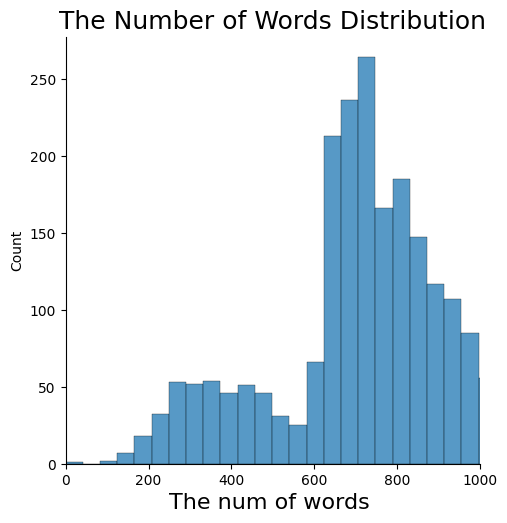

In [33]:
plt.figure(figsize= (8, 8))

sns.displot(data['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

Text preprocessing

In [10]:
def preprocess_text(text):

    # Tokenization
    tokens = word_tokenize(text.lower())

    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    
    return lemmatized_tokens


Add preprocessed texts as new columns

In [11]:
data['preprocessed_text'] = data['Resume_str'].apply(preprocess_text)

Encode labels using LabelEncoder

In [12]:
# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['Category'])

Split dataset into train and test sets


In [13]:
# Split dataset into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Check Imbalance

In [36]:
category_count = data['Category'].value_counts()

categories = category_count.index

category_count

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

Plot category figure

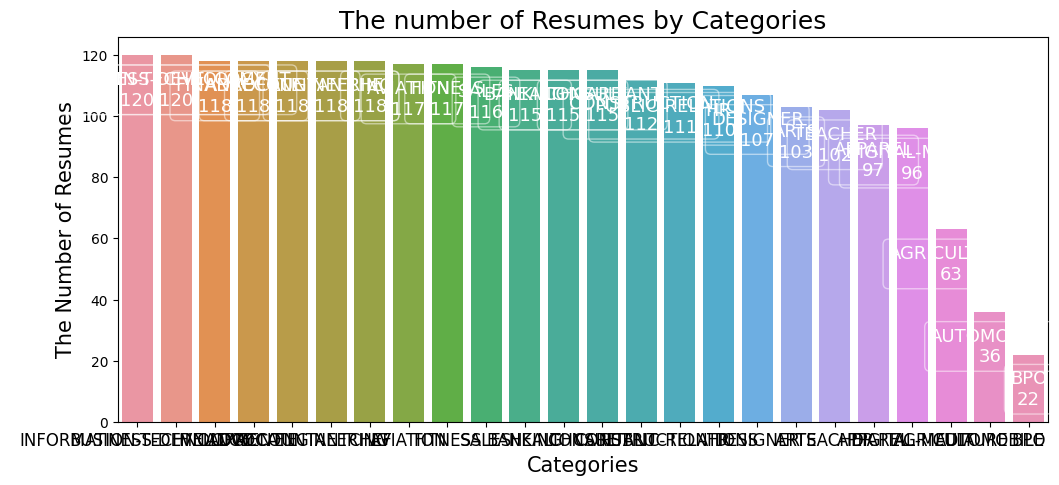

In [37]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of Resumes', size= 15)

plt.xticks(size = 12)

plt.title("The number of Resumes by Categories" , size = 18)

plt.show()

Handle class imbalance using resampling


In [38]:
# Handle class imbalance using resampling
majority_class = train_data['encoded_label'].value_counts().idxmax()
minority_classes = train_data['encoded_label'].value_counts().idxmin()

# Upsample minority classes
upsampled_data = []
for label in train_data['encoded_label'].unique():
    if label == majority_class:
        upsampled_data.append(train_data[train_data['encoded_label'] == label])
    else:
        minority_class_data = train_data[train_data['encoded_label'] == label]
        upsampled_data.append(resample(minority_class_data, replace=True, n_samples=len(train_data[train_data['encoded_label'] == majority_class]), random_state=42))

train_data_upsampled = pd.concat(upsampled_data)

Plot category figure of upsampled data

In [43]:
category_count = train_data_upsampled['Category'].value_counts()

categories = category_count.index

category_count

Category
AVIATION                  99
HEALTHCARE                99
APPAREL                   99
TEACHER                   99
ACCOUNTANT                99
SALES                     99
ARTS                      99
ENGINEERING               99
PUBLIC-RELATIONS          99
DIGITAL-MEDIA             99
BUSINESS-DEVELOPMENT      99
CONSTRUCTION              99
HR                        99
CONSULTANT                99
AGRICULTURE               99
AUTOMOBILE                99
INFORMATION-TECHNOLOGY    99
BANKING                   99
FINANCE                   99
CHEF                      99
FITNESS                   99
ADVOCATE                  99
DESIGNER                  99
BPO                       99
Name: count, dtype: int64

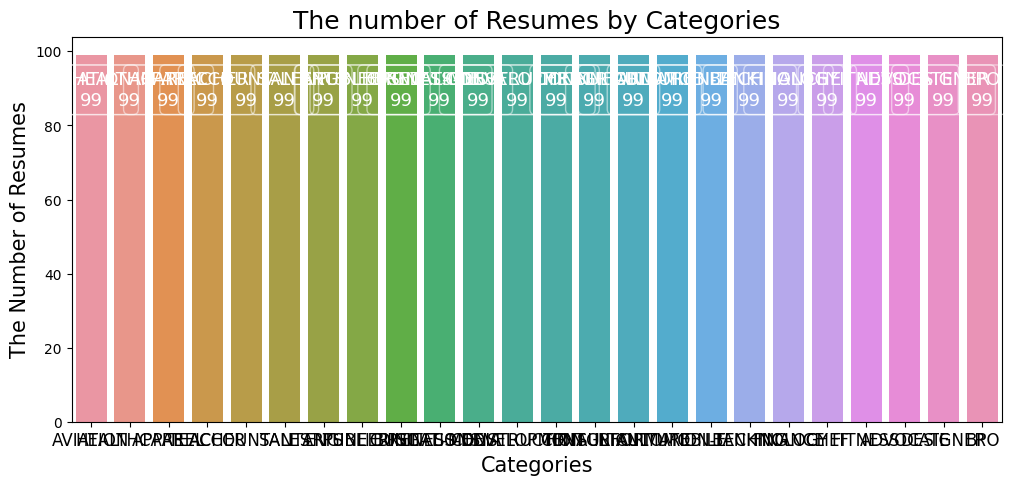

In [44]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of Resumes', size= 15)

plt.xticks(size = 12)

plt.title("The number of Resumes by Categories" , size = 18)

plt.show()

Tokenize and pad the text data

In [16]:
# Tokenize and pad the text data
max_words = 1000  
max_seq_length = 200  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data_upsampled['preprocessed_text'])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data_upsampled['preprocessed_text']), maxlen=max_seq_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['preprocessed_text']), maxlen=max_seq_length)

y_train = tf.keras.utils.to_categorical(train_data_upsampled['encoded_label'], num_classes=len(label_encoder.classes_))
y_test = tf.keras.utils.to_categorical(test_data['encoded_label'], num_classes=len(label_encoder.classes_))

Build the LSTM model

In [18]:
# Define LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length),
    LSTM(128, dropout=0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

2023-08-13 21:10:10.097011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-13 21:10:10.099653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-13 21:10:10.101673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Compile LSTM model

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train LSTM model

In [21]:
# Train the model
batch_size = 32
epochs = 10
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10


2023-08-13 21:13:36.539304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-13 21:13:36.541728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-13 21:13:36.543756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

75/75 [==============================] - ETA: 0s - loss: 3.1482 - accuracy: 0.0795

2023-08-13 21:13:54.358279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-13 21:13:54.360714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-13 21:13:54.362881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

75/75 [==============================] - 19s 229ms/step - loss: 3.1482 - accuracy: 0.0795 - val_loss: 3.1287 - val_accuracy: 0.0845
Epoch 2/10
75/75 [==============================] - 17s 230ms/step - loss: 2.9703 - accuracy: 0.1435 - val_loss: 2.9452 - val_accuracy: 0.0966
Epoch 3/10
75/75 [==============================] - 23s 306ms/step - loss: 2.7637 - accuracy: 0.1772 - val_loss: 2.9206 - val_accuracy: 0.0966
Epoch 4/10
75/75 [==============================] - 17s 220ms/step - loss: 2.5407 - accuracy: 0.2353 - val_loss: 2.8633 - val_accuracy: 0.1408
Epoch 5/10
75/75 [==============================] - 18s 238ms/step - loss: 2.3448 - accuracy: 0.3321 - val_loss: 2.8812 - val_accuracy: 0.1308
Epoch 6/10
75/75 [==============================] - 18s 239ms/step - loss: 2.1171 - accuracy: 0.3843 - val_loss: 2.9010 - val_accuracy: 0.1569
Epoch 7/10
75/75 [==============================] - 20s 266ms/step - loss: 1.8139 - accuracy: 0.4840 - val_loss: 2.9915 - val_accuracy: 0.1489
Epoch 8/10

Save LSTM model

In [22]:
model.save('resume_classification_lstm_model.h5')

# Distilbert Model (Used Google Colab for GPU)

As be

Upsample the whole dataset

In [46]:
# Handle class imbalance using resampling
from sklearn.utils import resample

majority_class = data['Category'].value_counts().idxmax()
minority_classes = data['Category'].value_counts().idxmin()

# Upsample minority classes
upsampled_data = []
for label in data['Category'].unique():
    if label == majority_class:
        upsampled_data.append(data[data['Category'] == label])
    else:
        minority_class_data = data[data['Category'] == label]
        upsampled_data.append(resample(minority_class_data, replace=True, n_samples=len(data[data['Category'] == majority_class]), random_state=42))

data_upsampled = pd.concat(upsampled_data)

In [47]:
data_upsampled.Category.value_counts()

Category
HR                        120
DESIGNER                  120
ARTS                      120
BANKING                   120
PUBLIC-RELATIONS          120
CONSTRUCTION              120
ACCOUNTANT                120
ENGINEERING               120
APPAREL                   120
FINANCE                   120
CHEF                      120
AUTOMOBILE                120
DIGITAL-MEDIA             120
CONSULTANT                120
SALES                     120
BPO                       120
AGRICULTURE               120
FITNESS                   120
HEALTHCARE                120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  120
TEACHER                   120
INFORMATION-TECHNOLOGY    120
AVIATION                  120
Name: count, dtype: int64

In [48]:
data_upsampled['encoded_text'] = data_upsampled['Category'].astype('category').cat.codes

data_upsampled.head(10)

,ID,Resume_str,Resume_html,Category,count,encoded_text
102,10399912,HR PERSONNEL ASSISTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",HR,720,19
51,39650734,HR ASSISTANT Summary Har...,"<div class=""fontsize fontface vmargins hmargin...",HR,917,19
92,23510685,GLOBAL HR MANAGER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",HR,846,19
14,27490876,HR COORDINATOR Summary App...,"<div class=""fontsize fontface vmargins hmargin...",HR,724,19
106,24402267,DESIGNATION: HR ASSISTANT Profe...,"<div class=""fontsize fontface vmargins hmargin...",HR,807,19
71,14640322,HR GENERALIST Summary H...,"<div class=""fontsize fontface vmargins hmargin...",HR,717,19
60,39081840,HR COORDINATOR Summary To o...,"<div class=""fontsize fontface vmargins hmargin...",HR,979,19
20,30163002,HR GENERALIST Summary Yo...,"<div class=""fontsize fontface vmargins hmargin...",HR,620,19
102,10399912,HR PERSONNEL ASSISTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",HR,720,19
82,11698189,HR EMPLOYEE RELATIONS SPECIALIST ...,"<div class=""fontsize fontface vmargins hmargin...",HR,511,19


Define dependent and independent variables

In [49]:
data_texts = data_upsampled['Resume_str'].to_list()

data_labels = data_upsampled['encoded_text'].to_list()

In [50]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )

train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

Model Definition

In [51]:
### Model Definition

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=24)


In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5 )


trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

# Define argparse to classify PDF resumes and create output directories


Takes arguments as: <br> 
<br>Input directory containing PDF resumes
<br>Output directory for categorized resumes
<br>Number of PDF resumes to classify

In [ ]:
# Define argparse to classify PDF resumes and create output directories
parser = argparse.ArgumentParser(description='Classify PDF resumes and create output directories.')
parser.add_argument('--input_dir', type=str, default='pdf_resumes', help='Input directory containing PDF resumes')
parser.add_argument('--output_dir', type=str, default='classified_resumes', help='Output directory for categorized resumes')
parser.add_argument('--num_pdfs', type=int, default=10, help='Number of PDF resumes to classify')
args = parser.parse_args()

In [ ]:
# Create output directory
output_dir = args.output_dir
os.makedirs(output_dir, exist_ok=True)

# Classify random PDF resumes and move to respective output directories
pdf_directory = args.input_dir  
pdf_files = [file for file in os.listdir(pdf_directory) if file.endswith('.pdf')]
selected_pdfs = np.random.choice(pdf_files, size=args.num_pdfs, replace=False)

for pdf_file in selected_pdfs:
    pdf_path = os.path.join(pdf_directory, pdf_file)
    pdf_document = fitz.open(pdf_path)
    text = ""
    for page_num in range(pdf_document.page_count):
        page = pdf_document[page_num]
        text += page.get_text()
    pdf_document.close()

    preprocessed_text = preprocess_text(text)
    sequence = pad_sequences(tokenizer.texts_to_sequences([preprocessed_text]), maxlen=max_seq_length)
    input_tensor = tf.convert_to_tensor(sequence)
    
    y_pred = model.predict(input_tensor)
    predicted_label = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
    
    output_category_dir = os.path.join(output_dir, predicted_label[0])
    os.makedirs(output_category_dir, exist_ok=True)
    output_path = os.path.join(output_category_dir, pdf_file)
    
    # Move the PDF to the output directory
    os.rename(pdf_path, output_path)

# Generate CSV file
output_csv = os.path.join(output_dir, 'categorized_resumes.csv')
results = []
for category in os.listdir(output_dir):
    if os.path.isdir(os.path.join(output_dir, category)):
        for resume_file in os.listdir(os.path.join(output_dir, category)):
            if resume_file.endswith(".pdf"):
                results.append({'filename': resume_file, 'category': category})
results_df = pd.DataFrame(results)
results_df.to_csv(output_csv, index=False)

print("Randomly selected PDF resumes classified and moved to respective directories.")